In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


Looking in indexes: https://download.pytorch.org/whl/cpu


In [ ]:
!pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 49.3 MB/s eta 0:00:00


Epoch 1/10, Train Loss: 3.1011, Val Loss: 1.6858
Epoch 2/10, Train Loss: 1.5911, Val Loss: 1.7283
Epoch 3/10, Train Loss: 1.5808, Val Loss: 1.6948
Epoch 4/10, Train Loss: 1.6085, Val Loss: 1.6694
Epoch 5/10, Train Loss: 1.3440, Val Loss: 1.3003
Epoch 6/10, Train Loss: 1.0556, Val Loss: 1.0872
Epoch 7/10, Train Loss: 0.8890, Val Loss: 0.8283
Epoch 8/10, Train Loss: 0.6966, Val Loss: 0.6421
Epoch 9/10, Train Loss: 0.5227, Val Loss: 0.9425
Epoch 10/10, Train Loss: 0.3893, Val Loss: 0.6524
Confusion Matrix:
[[41  0  1  0  0  2  0  0  0]
 [ 0 78  1  0  0  1  1  0  0]
 [ 0  0  3  0  0  0  2  0  0]
 [ 0  0  0  2  0  1  2  0  0]
 [ 0  0  0  0  6  0  1  0  0]
 [ 2  2  0  0  0  2  1  1  0]
 [ 0  0  0  0  0  1  7  2  0]
 [ 0  0  0  0  0  1  4  2  1]
 [ 2  1  2  0  0  1  0  0  0]]
Accuracy: 81.03%
F1-Score: 0.8029
AUC Score: 0.9731
Classification Report:
               precision    recall  f1-score   support

       Faces       0.91      0.93      0.92        44
  Motorbikes       0.96      0.96  

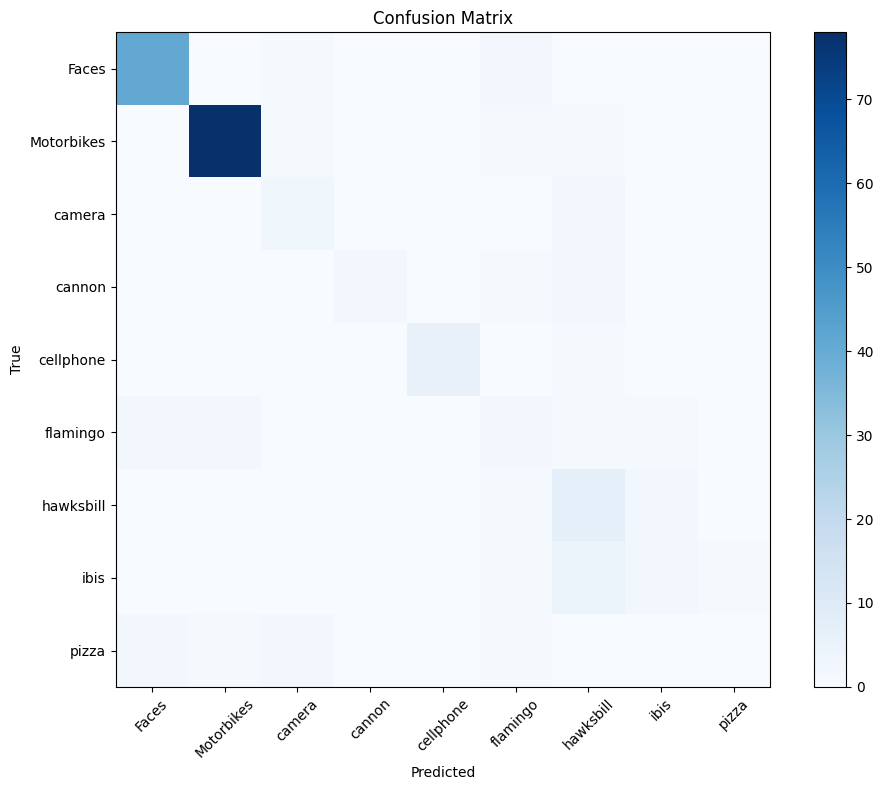

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
import numpy as np


# Dataset Paths
train_dir = "/content/train"
val_dir = "/content/val"
test_dir = "/content/test"

# Transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# CNN Model
class GishActivation(nn.Module):
    def forward(self, x):
        return torch.log(1 + torch.exp(x))

class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.gish = GishActivation()
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(self.gish(self.conv1(x)))
        x = self.pool(self.gish(self.conv2(x)))
        x = self.pool(self.gish(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = self.gish(self.fc1(x))
        x = self.fc2(x)
        return x

# Model Initialization
model = CNNModel(len(train_dataset.classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40], gamma=0.3)

# Training Function
def train_model(model, train_loader, val_loader, epochs):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()

        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

# Train Model
train_model(model, train_loader, val_loader, epochs=10)

# Save Model
torch.save(model.state_dict(), "cnn_model.pth")

# Evaluate Model on Test Data
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        preds = torch.argmax(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

# Metrics
cm = confusion_matrix(all_labels, all_preds)
accuracy = (cm.diagonal().sum() / cm.sum()) * 100
f1 = f1_score(all_labels, all_preds, average='weighted')

# Compute AUC Score
all_probs = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        probs = nn.functional.softmax(outputs, dim=1)
        all_probs.extend(probs.numpy())

auc_score = roc_auc_score(
    np.eye(len(train_dataset.classes))[all_labels],
    np.array(all_probs),
    average='weighted',
    multi_class='ovr'
)

# Classification Report
classification_rep = classification_report(all_labels, all_preds, target_names=train_dataset.classes)

def save_results_to_pdf(cm, accuracy, f1, auc_score, classification_rep, filename="results.pdf"):
    pdf = canvas.Canvas(filename, pagesize=letter)
    pdf.setTitle("CNN Results")

    # Başlık
    pdf.setFont("Helvetica-Bold", 16)
    pdf.drawString(50, 750, "Model Evaluation Results")

    # Confusion Matrix Yazdırma
    pdf.setFont("Helvetica", 12)
    pdf.drawString(50, 720, "Confusion Matrix:")
    y = 700  # Başlangıç Y koordinatı
    for row in cm:
        pdf.drawString(50, y, str(row))
        y -= 20  # Her satır için Y koordinatını azalt

    # Diğer Metrikler
    y -= 20  # Biraz boşluk bırak
    pdf.drawString(50, y, f"Accuracy: {accuracy:.2f}%")
    y -= 20
    pdf.drawString(50, y, f"F1-Score: {f1:.4f}")
    y -= 20
    pdf.drawString(50, y, f"AUC Score: {auc_score:.4f}")

    # Classification Report Yazdırma
    y -= 40
    pdf.setFont("Helvetica-Bold", 14)
    pdf.drawString(50, y, "Classification Report:")
    y -= 20
    pdf.setFont("Helvetica", 10)
    for line in classification_rep.split("\n"):
        pdf.drawString(50, y, line)
        y -= 15  # Her satır için Y koordinatını azalt

    pdf.save()



save_results_to_pdf(cm, accuracy, f1, auc_score, classification_rep, "results.pdf")

# Display Metrics
print(f"Confusion Matrix:\n{cm}")
print(f"Accuracy: {accuracy:.2f}%")
print(f"F1-Score: {f1:.4f}")
print(f"AUC Score: {auc_score:.4f}")
print("Classification Report:\n", classification_rep)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(train_dataset.classes)), train_dataset.classes, rotation=45)
plt.yticks(range(len(train_dataset.classes)), train_dataset.classes)
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()
